<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multi–Armed-Bandit-for-Pricing" data-toc-modified-id="Multi–Armed-Bandit-for-Pricing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multi–Armed Bandit for Pricing</a></span><ul class="toc-item"><li><span><a href="#Demand-modelling" data-toc-modified-id="Demand-modelling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Demand modelling</a></span></li><li><span><a href="#Run-simulations" data-toc-modified-id="Run-simulations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Run simulations</a></span></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Multi–Armed Bandit for Pricing

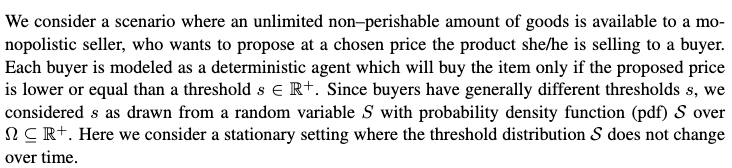

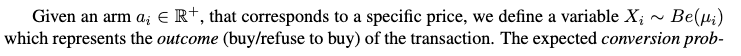
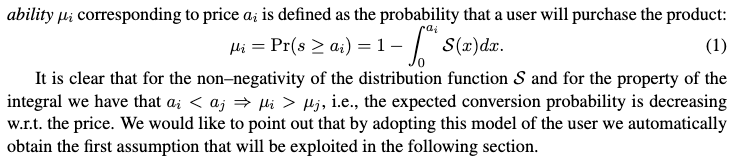

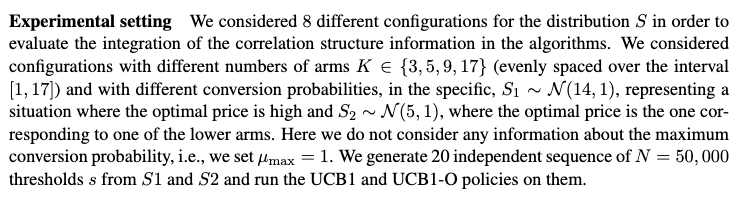

basically:
1. Get pdf of S
2. Each arm has price $a_i$ associated with it.
3. If we pull arm $i$, then we would receive $X_i \sim Be(\mu_i)$, $\mu_i=1-P(s \le a_i)$$

So we can implement it wrapping the `BernoulliBandit`

I can also use **exponential** distribution for better modelling

bernoulli bandit is used below

In [3]:
import itertools

import scipy.stats as ss
from joblib import Parallel, delayed

from bandits.pricing.bandits import PricingBernoulliBanditEnv
from bandits.pricing.agents import UCB1OAgent, SLRAgent

from bandits.bandits import BernoulliBanditEnv
from bandits.agents import EpsilonGreedyAgent, UCB1Agent, ThompsonSamplingBetaAgent

### Demand modelling

In [4]:
np.random.seed(2)
N_SIMULATIONS = 10
T = 2000

eps = 1e-2  # probability of exploration
alpha = 1

In [5]:
p_min = 1
p_max = 10
K = 9
dist_mean = 5
dist_std = 2  # note: I increased it to 6
dist = ss.norm(loc=dist_mean, scale=dist_std)

<>:12: DeprecationWarning: invalid escape sequence \s
<>:21: DeprecationWarning: invalid escape sequence \m


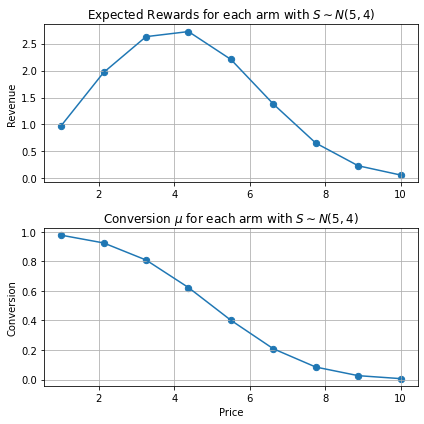

In [6]:
fig,axs=plt.subplots(figsize=(6, 6))

plt.subplot(2, 1, 1)
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)
rewards = arms*mus
plt.plot(arms, rewards)
plt.scatter(arms, rewards, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Revenue')
plt.title('Expected Rewards for each arm with $S \sim N(5, 4)$');

plt.subplot(2, 1, 2)
plt.plot(arms, mus)
plt.scatter(arms, mus, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Conversion')
plt.xlabel('Price')
plt.title('Conversion $\mu$ for each arm with $S \sim N(5, 4)$')
fig.tight_layout();

### Run simulations

In [7]:
np.random.seed(2)
N_SIMULATIONS = 50
T = 10000

eps = 1e-2  # probability of exploration
alpha = 1

In [8]:
p_min = 1
p_max = 10
K = 9
dist_mean = 2
dist_std = 3
dist = ss.norm(loc=dist_mean, scale=dist_std)

<>:12: DeprecationWarning: invalid escape sequence \s
<>:21: DeprecationWarning: invalid escape sequence \m


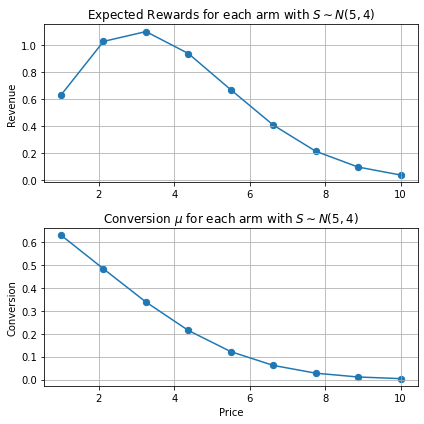

In [9]:
fig,axs=plt.subplots(figsize=(6, 6))

plt.subplot(2, 1, 1)
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)
rewards = arms*mus
plt.plot(arms, rewards)
plt.scatter(arms, rewards, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Revenue')
plt.title('Expected Rewards for each arm with $S \sim N(5, 4)$');

plt.subplot(2, 1, 2)
plt.plot(arms, mus)
plt.scatter(arms, mus, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Conversion')
plt.xlabel('Price')
plt.title('Conversion $\mu$ for each arm with $S \sim N(5, 4)$')
fig.tight_layout();

In [10]:
def simulate_agent(T, K, dist, p_min, p_max, agent_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    env = PricingBernoulliBanditEnv(num_arms=K, dist=dist, p_min=p_min, p_max=p_max)
    # print(env.max_reward)
    # print(env.mus.round(3))
    # print(env.mus * env.action_to_price)
    
    name, agent_func = agent_tuple
    agent = agent_func(env)
    observation = env.reset()  # initial observation
    reward_history = []
    for _ in range(T):
        # print('choosing action')
        action = agent.get_action(observation)
        observation, reward, done, info = env.step(action)
        # print('step', observation, reward, done, info)
        reward_history.append(reward)
        agent.update_estimates(action, observation, reward)
    env.close()
    
    regret = np.cumsum(env.max_reward - reward_history)
    return rng_seed, name, regret

In [11]:
agent_funcs = [
    ("UCB1", lambda env: UCB1Agent(alpha=alpha, num_arms=env.action_space.n, reward_normalization=2*p_max)),
    ("UCB1-O", lambda env: UCB1OAgent(alpha=alpha, action_to_price=env.action_to_price)),
    ("SLRAgent", lambda env: SLRAgent(alpha=alpha, action_to_price=env.action_to_price)),
]

Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [12]:
# # just to check if it works
# for n_simulation, agent_tuple in tqdm(combinations):
#     simulate_agent(T, K, dist, p_min, p_max, agent_tuple, n_simulation)
#     break

In [13]:
n_jobs = 8
verbose = False

results = Parallel(n_jobs=n_jobs, backend='loky', verbose=verbose)(
    delayed(simulate_agent)(T, K, dist, p_min, p_max, agent_tuple, n_simulation) for n_simulation, agent_tuple in tqdm(combinations))

  0%|          | 0/150 [00:00<?, ?it/s]

In [14]:
results_df = pd.DataFrame(results, columns=['simulation', 'algorithm', 'regret'])

In [15]:
results_df.head()

,simulation,algorithm,regret
0,0,UCB1,"[0.09999863840974155, -0.9250027231805169, 0.1..."
1,0,UCB1-O,"[0.09999863840974155, -0.9250027231805169, 0.1..."
2,0,SLRAgent,"[0.09999863840974155, -0.9250027231805169, 0.1..."
3,1,UCB1,"[0.09999863840974155, 1.199997276819483, 2.299..."
4,1,UCB1-O,"[0.09999863840974155, 1.199997276819483, 2.299..."


In [16]:
agent_to_regret = results_df.groupby('algorithm').apply(lambda x: np.array(x['regret'].to_list())).to_dict()

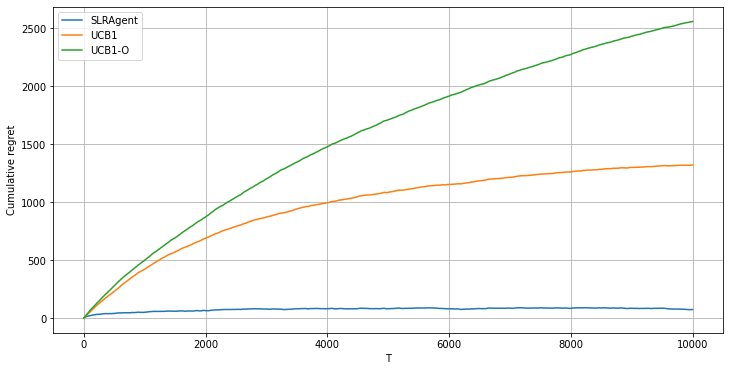

In [17]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for name, regret in agent_to_regret.items():
    sns.lineplot(x=ts, y=np.mean(regret, axis=0), label=name)
plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

In [18]:
agents = ['UCB1-O', 'SLRAgent']
relative_regrets = {}

ucb1_regret_cumsum = np.mean(agent_to_regret['UCB1'], axis=0)
for agent_name in agents:
    regret_cumsum = np.mean(agent_to_regret[agent_name], axis=0)
    relative_regret = regret_cumsum/ucb1_regret_cumsum

    # removing the first observations for numerical stability
    relative_regret = relative_regret[100:]
    
    relative_regrets[agent_name] = relative_regret

UCB1-O
SLRAgent


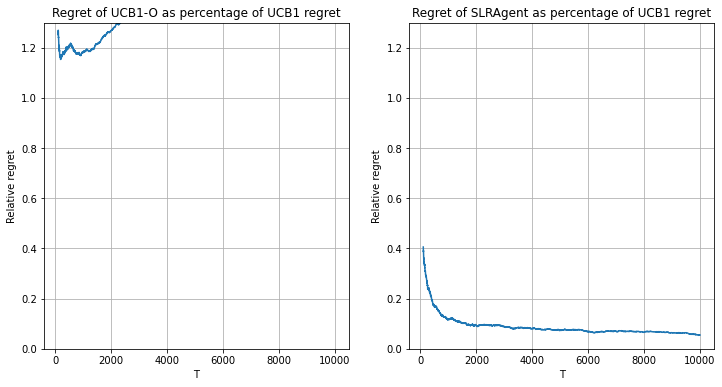

In [19]:
fig,axs=plt.subplots(figsize=(12, 6))


for i, agent_name in enumerate(agents):
    plt.subplot(1, 2, i+1)
    ts = np.arange(100, T)
    print(agent_name)
    plt.plot(ts, relative_regrets[agent_name])
    plt.xlabel('T')
    plt.ylabel('Relative regret')
    plt.title(f'Regret of {agent_name} as percentage of UCB1 regret')
    plt.grid()
    plt.ylim(0, 1.3);